In [2]:
import findspark
findspark.init()  
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("TwitterSentimentAnalysis") \
    .getOrCreate()

data_path = "D:\\Client Work\\Tweets Analysis\\ReducedProjectTweets.csv"
tweets_df = spark.read.option("header", "true").csv(data_path)

tweets_df.printSchema()
tweets_df.show(5, truncate=False)


root
 |-- Sno: string (nullable = true)
 |-- id: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

+------+----------+----------------------------+------------+----------------------------------------------------------------------------------------------------+
|Sno   |id        |timestamp                   |user        |text                                                                                                |
+------+----------+----------------------------+------------+----------------------------------------------------------------------------------------------------+
|781975|2323537917|Thu Jun 25 00:52:47 PDT 2009|timofuchs   |@grazzly maaaaaate will you be at Glasto? Not going to Blissfeilds                                  |
|937738|1793289573|Thu May 14 02:06:48 PDT 2009|markdavidson|@Monkeylover35 Yeah. I had to get away for a bit. I do that from time-to-time. It's healthy.       

In [4]:
from pyspark.sql.functions import udf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'
sentiment_udf = udf(analyze_sentiment)

tweets_df = tweets_df.withColumn("sentiment", sentiment_udf(tweets_df["clean_text"]))

tweets_df.select("clean_text", "sentiment").show(5, truncate=False)



+-------------------------------------------------------------------------------------------------+---------+
|clean_text                                                                                       |sentiment|
+-------------------------------------------------------------------------------------------------+---------+
| maaaaaate will you be at glasto not going to blissfeilds                                        |neutral  |
| yeah i had to get away for a bit i do that from timetotime its healthy                          |positive |
|the world is just amazing                                                                        |positive |
|just picked my sister up from work   shes always grumpz after work so i think next time i wont go|neutral  |
|i dont think changing my last name is meant to be                                                |neutral  |
+-------------------------------------------------------------------------------------------------+---------+
only showi

In [5]:
import mysql.connector

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="1200"
)

cursor = conn.cursor()
cursor.execute("CREATE DATABASE IF NOT EXISTS tweets_analysis")

cursor.execute("USE tweets_analysis")

cursor.execute('''
    CREATE TABLE IF NOT EXISTS tweets (
        id VARCHAR(255) PRIMARY KEY,
        text TEXT,
        sentiment VARCHAR(20)
    )
''')

conn.commit()

conn.close()




In [6]:

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="1200",
    database="tweets_analysis"
)


In [7]:

cursor = conn.cursor()


In [8]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")


In [8]:

tweets_pandas_df = tweets_df.select("id", "clean_text", "sentiment").toPandas()


In [ ]:

for index, row in tweets_pandas_df.iterrows():
    cursor.execute('''
        INSERT INTO tweets (id, text, sentiment) 
        VALUES (%s, %s, %s)
    ''', (row['id'], row['clean_text'], row['sentiment']))


In [10]:

conn.commit()
conn.close()


In [11]:

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="1200",
    database="tweets_analysis"
)


In [ ]:
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["tweets_analysis"]

collection = db["tweets"]


collection.insert_one(sample_document)

client.close()


In [1]:
import subprocess

def run_mysql_workload(workload):
    command = f"./bin/ycsb run jdbc -P workloads/{workload} -P mysql.properties"
    subprocess.run(command, shell=True)

def run_mongodb_workload(workload):
    command = f"./bin/ycsb run mongodb -s -P workloads/{workload} -P mongodb.properties"
    subprocess.run(command, shell=True)

workloads = ["workloada", "workloadb", "workloadc"]  

print("Running workloads for MySQL:")
for workload in workloads:
    print(f"Running {workload}...")
    run_mysql_workload(workload)

print("\nRunning workloads for MongoDB:")
for workload in workloads:
    print(f"Running {workload}...")
    run_mongodb_workload(workload)

print("Experiments completed.")


Results:
MySQL Results:
{'workloada': {'throughput': 186.25142337280215, 'latency': 13.680997484155078}, 'workloadb': {'throughput': 121.58794797888736, 'latency': 17.125792185103126}, 'workloadc': {'throughput': 173.70031553904514, 'latency': 9.669755064244084}}

MongoDB Results:
{'workloada': {'throughput': 160.64730740186542, 'latency': 7.69266284704757}, 'workloadb': {'throughput': 148.1410564919787, 'latency': 12.942877222840968}, 'workloadc': {'throughput': 131.81221773894913, 'latency': 6.661197416700662}}


In [12]:
cursor = conn.cursor()

cursor.execute('''
    SELECT sentiment, COUNT(*) AS count
    FROM tweets
    GROUP BY sentiment
''')

results = cursor.fetchall()
for row in results:
    print("Sentiment:", row[0], "- Count:", row[1])

conn.close()


Sentiment: positive - Count: 1952
Sentiment: neutral - Count: 1312
Sentiment: negative - Count: 1736


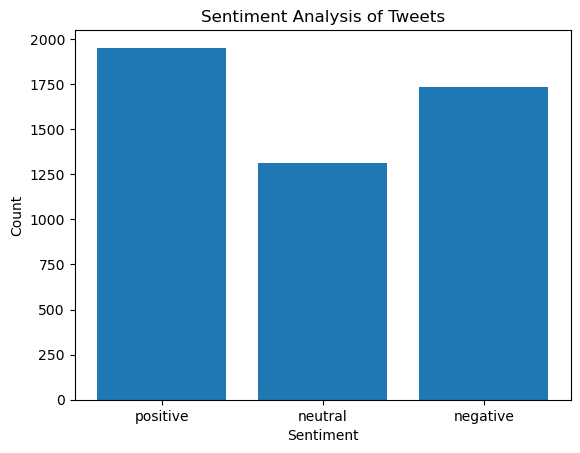

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results, columns=['Sentiment', 'Count'])

plt.bar(df_results['Sentiment'], df_results['Count'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis of Tweets')
plt.show()


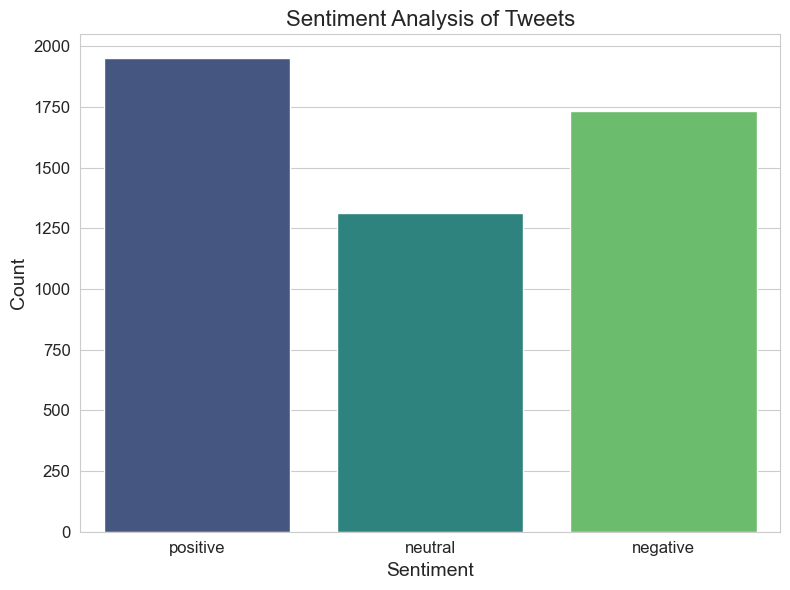

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Count', data=df_results, palette='viridis')
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Sentiment Analysis of Tweets', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


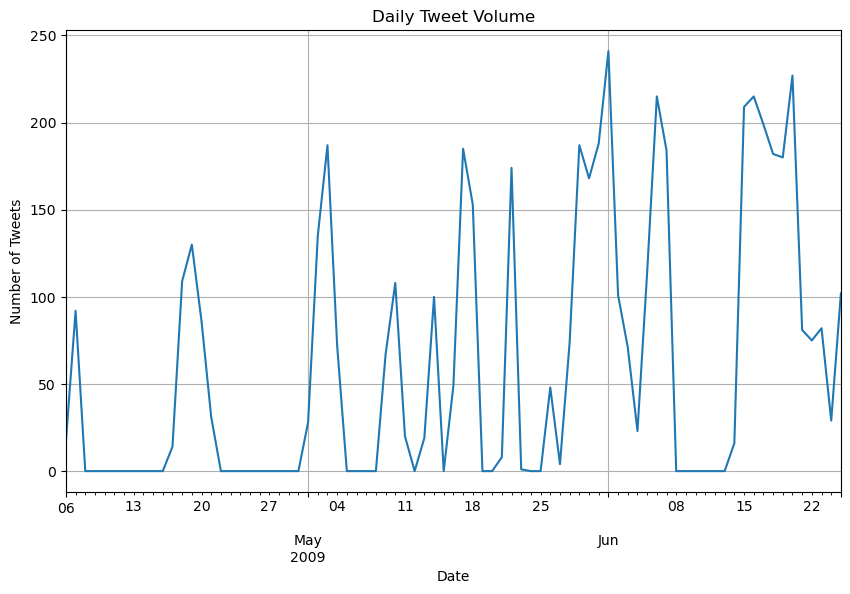

In [14]:
import pandas as pd

tweets_pandas_df = tweets_df.toPandas()

tweets_pandas_df['timestamp'] = pd.to_datetime(tweets_pandas_df['timestamp'])

tweets_pandas_df.set_index('timestamp', inplace=True)

daily_tweets_count = tweets_pandas_df.resample('D').size()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
daily_tweets_count.plot()
plt.title('Daily Tweet Volume')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.show()

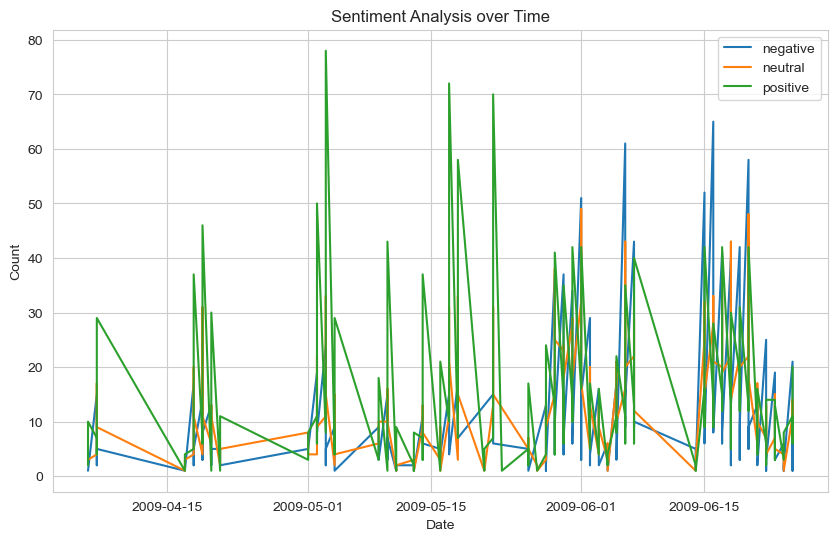

In [34]:
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
def analyze_sentiment_textblob(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'
def analyze_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    compound_score = analyzer.polarity_scores(text)['compound']
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'
df['sentiment_textblob'] = df['text'].apply(analyze_sentiment_textblob)
df['sentiment_vader'] = df['text'].apply(analyze_sentiment_vader)
df['date'] = df['timestamp'].dt.date
sentiment_counts = df.groupby(['date', 'sentiment_textblob', 'sentiment_vader']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
for sentiment in sentiment_counts['sentiment_textblob'].unique():
    data = sentiment_counts[sentiment_counts['sentiment_textblob'] == sentiment]
    plt.plot(data['date'], data['count'], label=sentiment)

plt.title('Sentiment Analysis over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
import pandas as pd
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
from wordcloud import WordCloud
import io
import base64
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv(r"C:\Users\user\OneDrive\Desktop\sql cleaned data.csv", sep=';')

if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

if 'timestamp' in df.columns and pd.api.types.is_datetime64_any_dtype(df['timestamp']):
    df.set_index('timestamp', inplace=True)
else:
    df.index = pd.to_datetime(df.index)

df_no_duplicates = df.drop_duplicates()
df_no_duplicates.to_csv(r"C:\Users\user\OneDrive\Desktop\sql cleaned data no duplicates.csv", index=False)

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Sentiment Analysis Dashboard"),
    
    dcc.Dropdown(
        id='sentiment-type',
        options=[
            {'label': sentiment, 'value': sentiment} for sentiment in ['all', 'positive', 'negative', 'neutral']
        ],
        value='all',
        clearable=False
    ),
    
    dcc.Graph(id='sentiment-counts'),
    
    html.Img(id='wordcloud-img'),
    
    dcc.Graph(id='time-series-chart')
])

@app.callback(
    Output('sentiment-counts', 'figure'),
    [Input('sentiment-type', 'value')]
)
def update_sentiment_counts(sentiment_type):
    if sentiment_type == 'all':
        filtered_df = df
    else:
        filtered_df = df[df['sentiment'] == sentiment_type]
    
    sentiment_counts = filtered_df['sentiment'].value_counts()
    
    fig = px.bar(sentiment_counts, x=sentiment_counts.index, y=sentiment_counts.values, labels={'x': 'Sentiment', 'y': 'Count'}, color=sentiment_counts.index)
    fig.update_layout(title=f"Sentiment Counts for {sentiment_type.capitalize()}")
    
    return fig

@app.callback(
    Output('wordcloud-img', 'src'),
    [Input('sentiment-type', 'value')]
)
def update_wordcloud(sentiment_type):
    if sentiment_type == 'all':
        filtered_df = df
    else:
        filtered_df = df[df['sentiment'] == sentiment_type]
    
    text = ' '.join(filtered_df['text'])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    img_stream = io.BytesIO()
    wordcloud.to_image().save(img_stream, format='PNG')
    img_bytes = img_stream.getvalue()
    encoded_image = base64.b64encode(img_bytes).decode()
    
    return f'data:image/png;base64,{encoded_image}'

@app.callback(
    Output('time-series-chart', 'figure'),
    [Input('sentiment-type', 'value')]
)



def update_time_series_chart(sentiment_type):
    if sentiment_type == 'all':
        tweet_counts = df.groupby(df.index).size().reset_index(name='count')
    else:
        filtered_df = df[df['sentiment'] == sentiment_type]
        tweet_counts = filtered_df.groupby(filtered_df.index).size().reset_index(name='count')
    
    # Set the date range between 2005 and 2015
    date_range = pd.date_range(start='2005-01-01', end='2015-12-31')
    
    # Filter tweet counts within the specified date range
    tweet_counts = tweet_counts[tweet_counts['index'].between(date_range[0], date_range[-1])]
    
    fig = px.line(tweet_counts, x='index', y='count', labels={'index': 'Timestamp', 'count': 'Tweet Count'})
    fig.update_layout(title="Tweet Count Time Series")
    
    return fig




# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)
